## Explore NER results notebook

This notebook does an exploratory check of the results to find out how many named entities were recognised in the different categories and which ones are more frequently mentioned.

### 1. Import and clean data

In [262]:
import pandas as pd
from pathlib import Path

path = Path(os.getcwd())
data_dir = os.path.join(path.parents[0], "data-files")

df = pd.read_csv(os.path.join(data_dir, "master-ner-results.csv"))
# drop rows in NaN values
df = df.dropna()
# remove unnecessary punctuation in entities
df['entity'] = df['entity'].str.replace('“','')
df['entity'] = df['entity'].str.replace('”','')
df['entity'] = df['entity'].str.replace('‘','')
df['entity'] = df['entity'].str.replace('’','')
df['entity'] = df['entity'].str.replace('()','', regex=False)
df['entity'] = df['entity'].str.replace('–-','')
# extend the number of dataframe rows pandas can display
pd.set_option('display.max_rows', 600)


In [263]:
# remove redundant 'the' at the start of named entities
containingThe = df.loc[df['entity'].str.startswith('the', na=False)] # entities starting with 'the'
notContainingThe = df.loc[~df['entity'].str.startswith('the', na=False)] # not starting with 'the'
# remove the 'the' in the named entity
containingThe['entity'] = containingThe['entity'].apply(lambda x: "" + x[3:])
# concatenate the cleaned dataframe (without the 'the' word) with the one not containing 'the'
df = pd.concat([containingThe, notContainingThe], axis=0)

/var/folders/yj/lbnnfnns43q55hrw_6bf0q780000gn/T/ipykernel_67686/3333905508.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  containingThe['entity'] = containingThe['entity'].apply(lambda x: "" + x[3:])


### 2. Display basic counts

In [264]:
# calculate the total no. of unique named entities
df['entity'] = df['entity'].str.lower() # lowercase entities to reduce duplicates according to case
n = len(pd.unique(df['entity']))
print("no. of unique named entities : ", n)

no. of unique named entities :  30805


In [265]:
# total unique named entities by entity type
entity_counts_by_type_df = df.groupby(['entity_type'])['entity'].nunique()
entity_counts_by_type_df

# relevant entity types:
# ----------------------
# FAC	building name
# GPE	geo-political entity
# LOC	location name
# NORP	affiliation
# ORG	organization name
# PERSON	person name

entity_type
FAC         531
GPE        4116
LOC        2753
NORP        291
ORG       17051
PERSON     7976
Name: entity, dtype: int64

In [266]:
# dataframes for each entity type
fac_df = df[df['entity_type'] == 'FAC']
gpe_df = df[df['entity_type'] == 'GPE']
loc_df = df[df['entity_type'] == 'LOC']
norp_df = df[df['entity_type'] == 'NORP']
org_df = df[df['entity_type'] == 'ORG']
per_df = df[df['entity_type'] == 'PERSON']

### 3. Further explore ORGs (organisations) only 

In [267]:
# check contents of organisations dataframe
org_df.head()

,entity,entity_type,sentence,span,docid,model
2,world water council,ORG,"The OECD, UCLG –Africa, the World Water Counci...",24:47,31,flair - FLERT and XML embeddings
4,oecd,ORG,This report is published as part of the OECD P...,36:44,31,flair - FLERT and XML embeddings
23,world water council,ORG,Angel Gurria OECD Secretary-General Abdelkader...,200:223,31,flair - FLERT and XML embeddings
24,oecd studies on water,ORG,Angel Gurria OECD Secretary-General Abdelkader...,363:388,31,flair - FLERT and XML embeddings
42,oecd,ORG,This report is also an output from the OECD Pr...,35:43,31,flair - FLERT and XML embeddings


In [268]:
# show the most mentioned and least mentioned named entities
org_df['entity'].value_counts()

oecd                                                                                 11736
ana                                                                                   1387
oecd publishing                                                                       1275
wss                                                                                    975
eu                                                                                     956
                                                                                     ...  
water treatment plant of reconquista                                                     1
the users council                                                                        1
a national federation of cooperatives of drinking water and other public services        1
upper austria water                                                                      1
colorado water court                                                                     1

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'oecd'),
  Text(1, 0, 'wss'),
  Text(2, 0, 'who'),
  Text(3, 0, 'jmp'),
  Text(4, 0, 'un'),
  Text(5, 0, 'aesn'),
  Text(6, 0, 'epa'),
  Text(7, 0, 'noaa'),
  Text(8, 0, 'wateraid'),
  Text(9, 0, 'huttonal')])

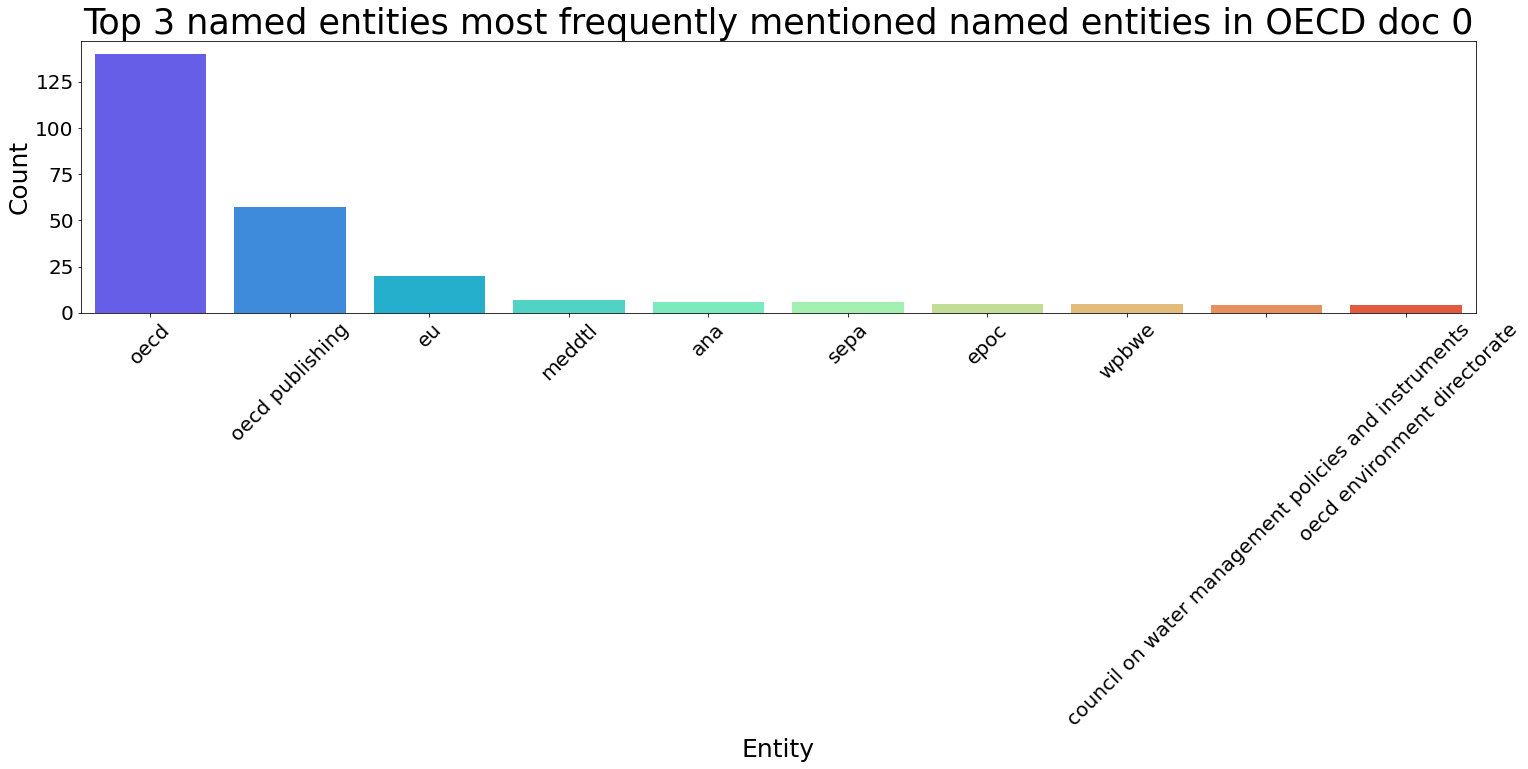

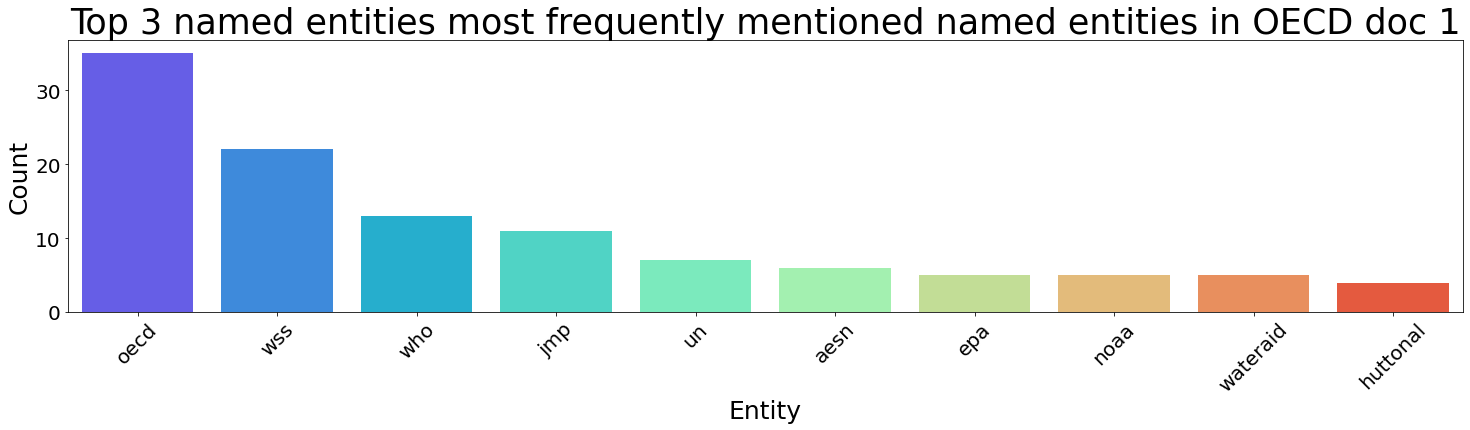

In [269]:
import pandas as pd
  
# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

# group frequency of named entities by document
org_df_onlydocs_and_ents = org_df.drop(['entity_type', 'sentence', 'span', 'model'], axis=1)
org_df_onlydocs_and_ents.reset_index()
filtered = org_df_onlydocs_and_ents.groupby('docid')['entity'].value_counts()
filtered = filtered.reset_index(name='count')
topn_df = pd.DataFrame()

for item in pd.unique(filtered['docid']):
    curr_dataf = filtered[filtered['docid'] == item]
    topn_df = pd.concat([topn_df, curr_dataf.head(10)], axis=0) 

plt.figure(figsize=(25,5))
s = sns.barplot(x='entity', y='count', data=topn_df[topn_df['docid'] == 0], palette='rainbow')
# plt.title("")
s.axes.set_title("Top 3 named entities most frequently mentioned named entities in OECD doc 0",fontsize=35)
s.set_xlabel("Entity",fontsize=25)
s.set_ylabel("Count",fontsize=25)
s.tick_params(labelsize=20)
plt.xticks(rotation=45)

plt.figure(figsize=(25,5))
s = sns.barplot(x='entity', y='count', data=topn_df[topn_df['docid'] == 1], palette='rainbow')
# plt.title("")
s.axes.set_title("Top 3 named entities most frequently mentioned named entities in OECD doc 1",fontsize=35)
s.set_xlabel("Entity",fontsize=25)
s.set_ylabel("Count",fontsize=25)
s.tick_params(labelsize=20)
plt.xticks(rotation=45)

# similar plots can be generated for other docs
# for later: generate and plot a frequency matrix for words in docs

In [272]:
# Generate word frequency matrix
import numpy as np

entities = list(set(topn_df['entity'].tolist()))
docs = list(set(topn_df['docid'].tolist()))
docs.sort()
matr = []
# print(topn_df)
for docid in docs:
    tmp = []
    for entity in entities:
        # print(type(entity))
        curr_row = topn_df.loc[(topn_df['entity'] == entity) & (topn_df['docid'] == docid)]
        if len(curr_row) == 0:
            tmp.append(0)
        else:
            # print(curr_row['count'].values[0])
            tmp.append(curr_row['count'].values[0])
    matr.append(tmp)

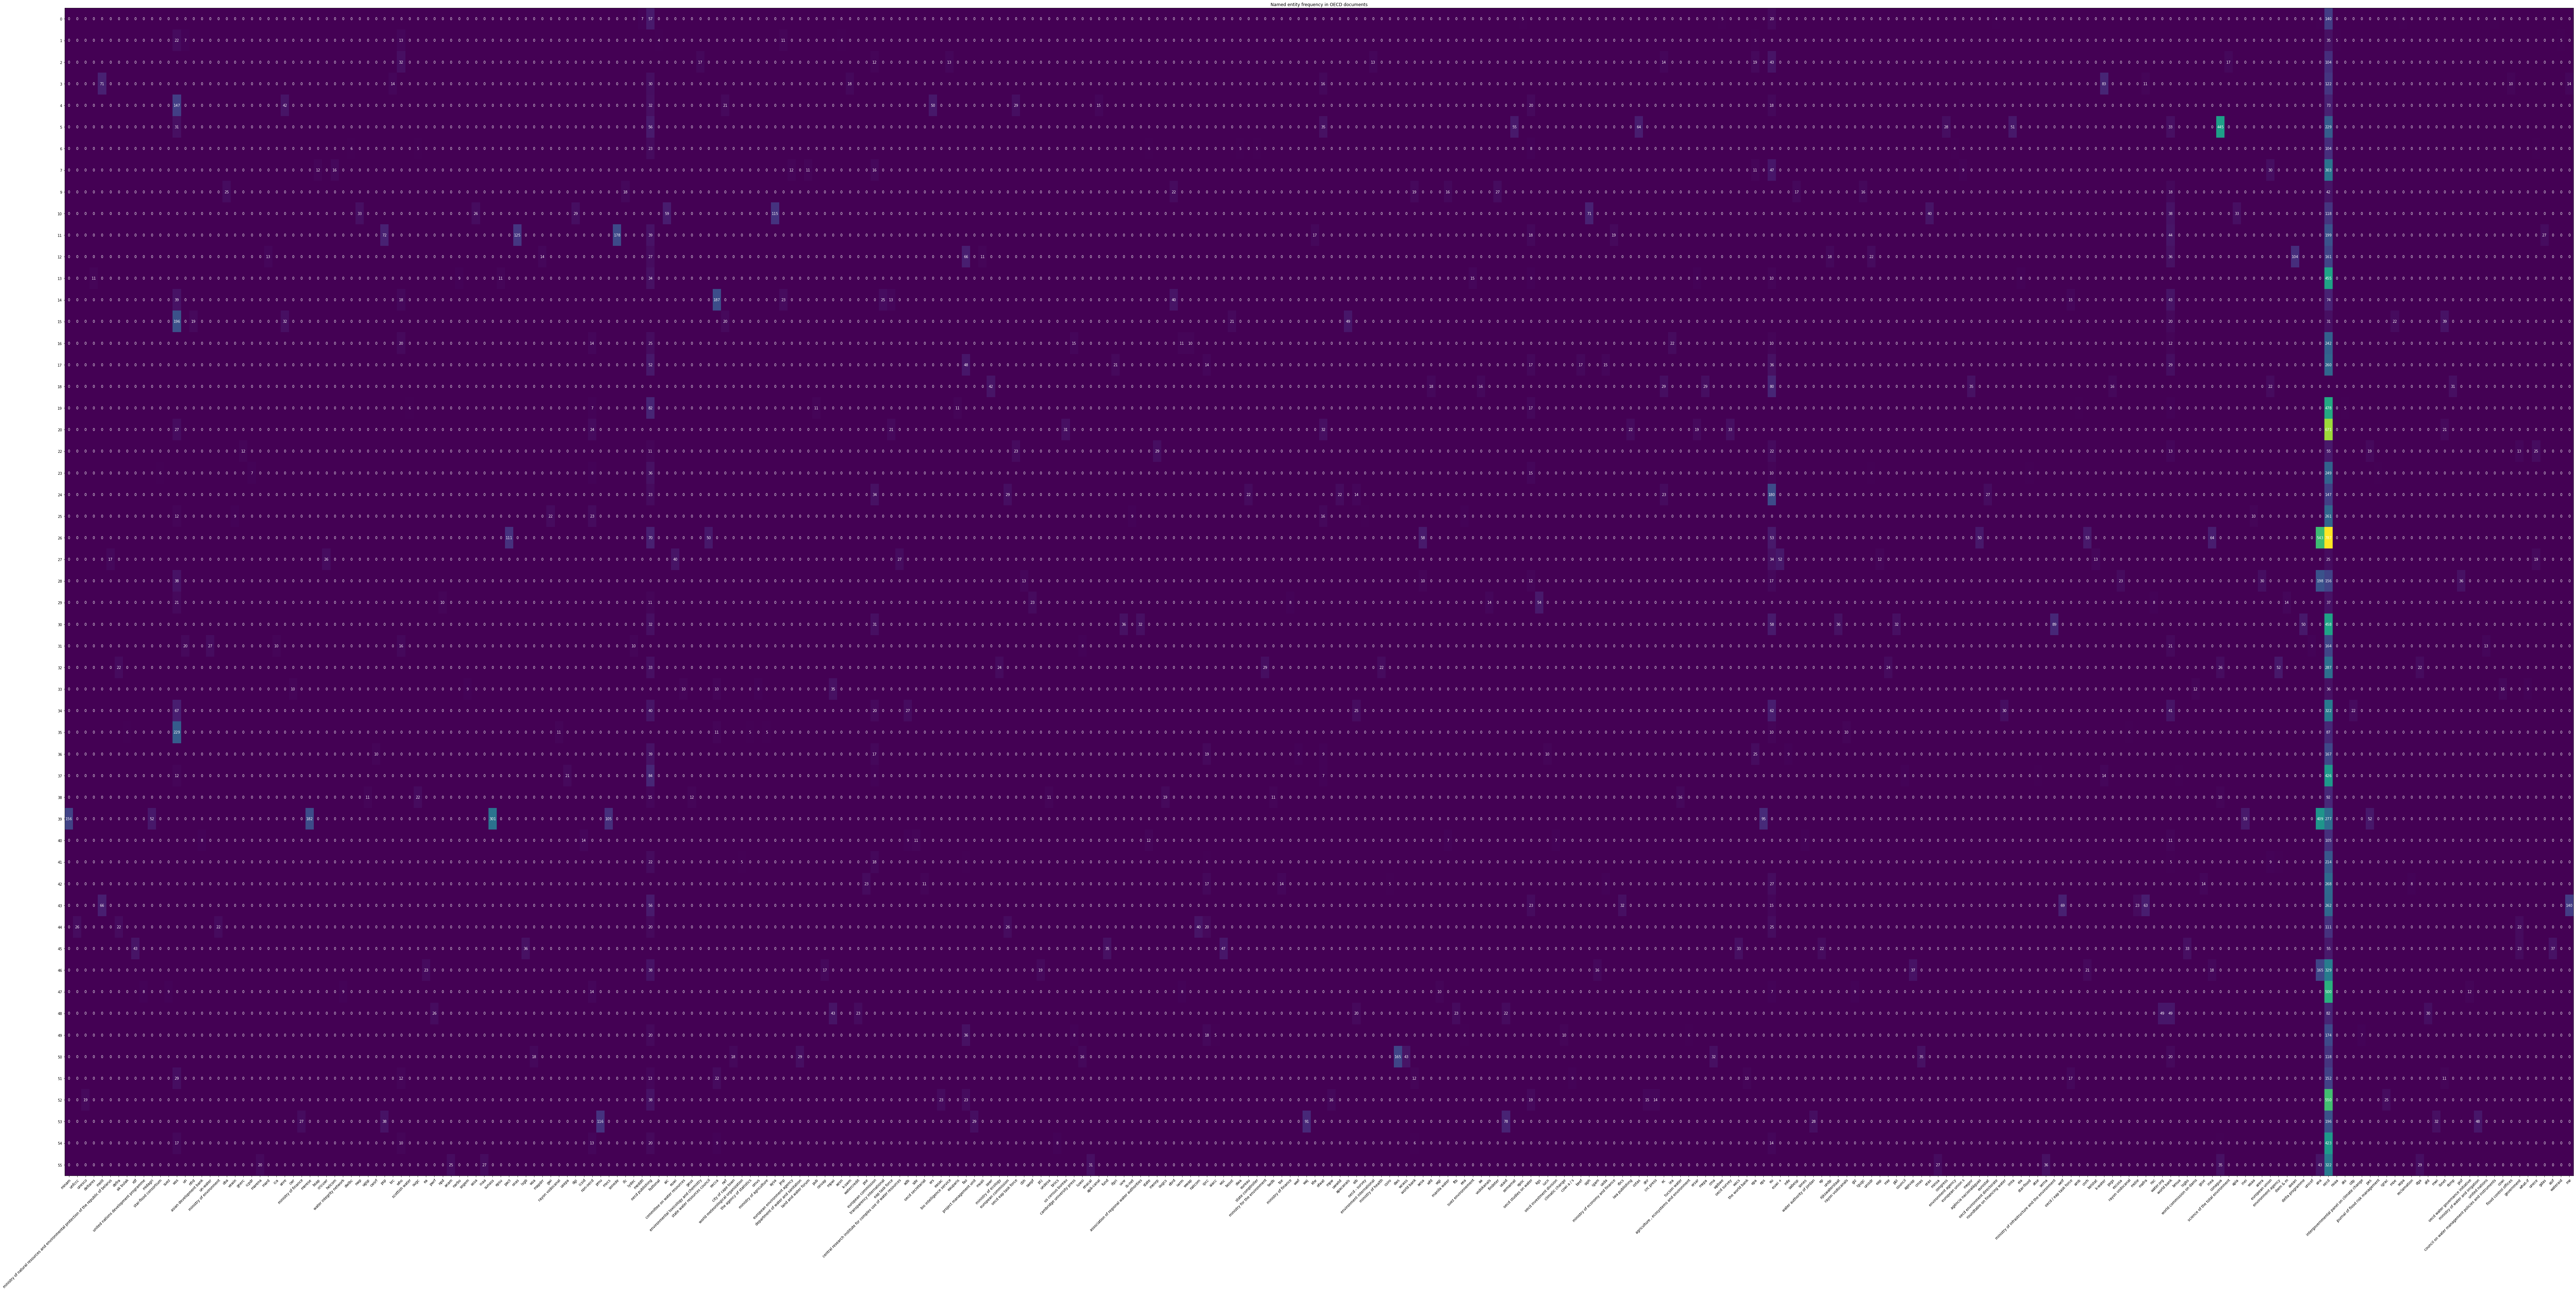

In [281]:
# Plot word frequency matrix 
matrix = np.array(matr)

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(100, 50))
im = ax.imshow(matrix, aspect='auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(entities)), labels=entities)
ax.set_yticks(np.arange(len(docs)), labels=docs)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(docs)):
    for j in range(len(entities)):
        text = ax.text(j, i, matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Distribution of the top 10 most frequently mentioned named entities in each OECD document")
fig.tight_layout()
plt.show()

In [282]:
# Occurrences of the "Rockefeller" foundation in the docs
org_df.loc[org_df['entity'].str.contains('Rockefeller', case=False)]

,entity,entity_type,sentence,span,docid,model
22453,rockefeller foundation,ORG,Initiated by the Presidential Hurricane Sandy ...,131:157,13,flair - FLERT and XML embeddings
23903,rockefeller foundation s,ORG,"In , Circle of Blue received the Rockefeller F...",29:57,13,flair - FLERT and XML embeddings
16601,the rockefeller foundation,ORG,"Downey, (), “Godzilla El Niño left Southern Ca...",378:404,17,flair - FLERT and XML embeddings
17727,rockefeller foundation,ORG,Water quality tradingbe effective to tackle wa...,175:197,17,flair - FLERT and XML embeddings
18173,rockefeller foundation,ORG,"Rockefeller Foundation (), “Incentive-based in...",0:22,17,flair - FLERT and XML embeddings
18177,the rockefeller foundation,ORG,"Rockefeller Foundation (), “Incentive-based in...",212:238,17,flair - FLERT and XML embeddings
63685,rockefeller foundation,ORG,The City Resilience Index (Box .) provides a h...,209:231,43,flair - FLERT and XML embeddings
63692,the rockefeller foundation,ORG,"Source: The Rockefeller Foundation/Arup (), Ci...",8:34,43,flair - FLERT and XML embeddings
63828,the rockefeller foundation,ORG,"The Economist (), Liquidity crisis, Water scar...",57:83,43,flair - FLERT and XML embeddings


In [283]:
# Top 20 most frequently mentioned entities ((seems to include more private and financial institutions)
from pandas.api.types import is_categorical_dtype

for col in org_df.columns:
    if (col not in ['sentence', 'span']):
        if (is_categorical_dtype(col)):
            display(pd.DataFrame(org_df[col].astype('str').value_counts().sort_values(ascending=False).head(20)))
        else:
            display(pd.DataFrame(org_df[col].value_counts().sort_values(ascending=False).head(20)))

,entity
oecd,11736
ana,1387
oecd publishing,1275
wss,975
eu,956
world bank,613
conagua,551
sunass,322
oecd studies on water,291
eecca,286


,entity_type
ORG,70743


,docid
39,5147
26,4984
5,2887
30,2668
32,2622
20,2523
10,2159
46,1969
13,1797
48,1792


,model
flair - FLERT and XML embeddings,70743


In [284]:
# Bottom 20 least frequently mentioned entities (seems to include more public / civil society institutions)
for col in org_df.columns:
    if (col not in ['sentence', 'span']):
        if (is_categorical_dtype(col)):
            display(pd.DataFrame(org_df[col].astype('str').value_counts().sort_values(ascending=True).head(20)))
        else:
            display(pd.DataFrame(org_df[col].value_counts().sort_values(ascending=True).head(20)))

,entity
brasileiraagênciasreguladoras,1
jakarta water supply regulatory body,1
regulatory agency for energy,1
national commission of the state public utilities,1
flemish environmental agency,1
advisory council of ersar,1
energy and water regulatory commission,1
state energy regulatory commission of bulgaria,1
competition and markets authorityintervene,1
energy and public utility regulatory authority,1


,entity_type
ORG,70743


,docid
1,324
6,430
41,469
0,475
29,519
51,558
35,559
25,561
49,577
22,579


,model
flair - FLERT and XML embeddings,70743
